In [73]:
ls

covid_19_india.csv  Indian_States.prj  Indian_States.shx
Indian_States.dbf   Indian_States.shp


In [74]:
# Install required library
!pip3 install calmap
!pip3 install bar_chart_race
!pip3 install pywaffle
!pip3 install folium
!pip install geopandas
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.9.0)


In [75]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import calmap
from datetime import datetime
import json
import requests
plt.style.use('fivethirtyeight')
%matplotlib inline

#bar chart race
import bar_chart_race as bcr

# Waffle Chart
from pywaffle import Waffle

# plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#geopandas
import geopandas as gpd

#folium
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801'

import warnings
warnings.filterwarnings("ignore")

import os


In [76]:
covid_19_india = pd.read_csv('covid_19_india.csv')

In [77]:
covid_19_india = covid_19_india.drop(['Sno','Time','ConfirmedIndianNational', 'ConfirmedForeignNational'], axis=1)
covid_19_india = covid_19_india.rename(columns={'State/UnionTerritory':'States','Cured':'Recovered'})

In [78]:
covid_19_india['Active'] = covid_19_india['Confirmed'] - covid_19_india['Recovered'] - covid_19_india['Deaths']
covid_19_india = covid_19_india.sort_values(['Date', 'States']).reset_index(drop=True)

In [79]:
covid_19_india['Date'] = pd.to_datetime(covid_19_india['Date'])

In [80]:
print(covid_19_india)

           Date                       States  ...  Confirmed  Active
0    2020-01-02                       Kerala  ...          2       2
1    2020-01-03                       Kerala  ...          3       3
2    2020-01-04  Andaman and Nicobar Islands  ...         10      10
3    2020-01-04               Andhra Pradesh  ...         83      82
4    2020-01-04                        Assam  ...          1       1
...         ...                          ...  ...        ...     ...
5856 2020-08-31                    Telengana  ...     124963   31299
5857 2020-08-31                      Tripura  ...      11644    4108
5858 2020-08-31                Uttar Pradesh  ...     225632   54666
5859 2020-08-31                  Uttarakhand  ...      19235    5912
5860 2020-08-31                  West Bengal  ...     159785   25657

[5861 rows x 6 columns]


In [81]:
india_wise_cases = covid_19_india[covid_19_india['Date'] == covid_19_india['Date'].max()].copy().fillna(0)
india_wise_cases.index = india_wise_cases["States"]
india_wise_cases = india_wise_cases.drop(['States', 'Date'], axis=1)

In [82]:
df = pd.DataFrame(pd.to_numeric(india_wise_cases.sum()),dtype=np.float64).transpose()
df.style.background_gradient(cmap='PuBu',axis=1)

,Recovered,Deaths,Confirmed,Active
0,1639599.000000,46091.000000,2329638.000000,643948.000000


In [83]:
df_last_date = covid_19_india[covid_19_india['Date'] == covid_19_india['Date'].max()]
temp = df_last_date.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp.reset_index(drop=True)


tm = temp.melt(id_vars="Date", value_vars=['Active', 'Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values="value", height=225, width=700,color_discrete_sequence=[act, rec, dth])
fig.data[0].textinfo = 'label+value'
fig.show()

In [84]:
india_wise_cases.sort_values('Confirmed', ascending= False).style\
    .background_gradient(cmap='BrBG_r', subset=['Confirmed'])\
    .background_gradient(cmap='YlGn_r', subset=["Deaths"])\
    .background_gradient(cmap='YlOrBr',subset=['Recovered'])\
    .background_gradient(cmap='summer_r', subset=['Active'])

,Recovered,Deaths,Confirmed,Active
States,,,,
Maharashtra,368435,18306,535601,148860
Tamil Nadu,250680,5159,308649,52810
Andhra Pradesh,154749,2203,244549,87597
Karnataka,105599,3398,188611,79614
Delhi,132384,4139,147391,10868
Uttar Pradesh,80589,2176,131763,48998
West Bengal,73395,2149,101390,25846
Bihar,56709,413,86413,29291
Telengana,61294,654,84544,22596


In [85]:
full_latest = covid_19_india[covid_19_india['Date'] == max(covid_19_india['Date'])]

In [86]:
print(full_latest)

           Date                                    States  ...  Confirmed  Active
2179 2020-12-08               Andaman and Nicobar Islands  ...       1764     994
2180 2020-12-08                            Andhra Pradesh  ...     244549   87597
2181 2020-12-08                         Arunachal Pradesh  ...       2327     690
2182 2020-12-08                                     Assam  ...      64406   19178
2183 2020-12-08                                     Bihar  ...      86413   29291
2184 2020-12-08                                Chandigarh  ...       1670     629
2185 2020-12-08                              Chhattisgarh  ...      12929    3586
2186 2020-12-08  Dadra and Nagar Haveli and Daman and Diu  ...       1653     442
2187 2020-12-08                                     Delhi  ...     147391   10868
2188 2020-12-08                                       Goa  ...       9444    2878
2189 2020-12-08                                   Gujarat  ...      73163   14024
2190 2020-12-08 

In [87]:
fig = px.treemap(full_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), path=["States"], values="Confirmed", height=700, title='Total Confirmed Cases')
fig.data[0].textinfo = 'label+text+value'
fig.show()

In [88]:
unique_states = covid_19_india['States'].unique()
plt.style.use("seaborn-talk")

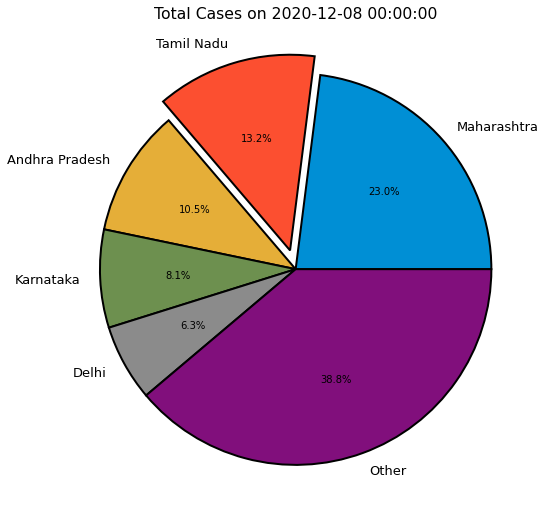

In [89]:
# Get last date to see which states have the most cases currently
last_date = covid_19_india['Date'].max()
df_last_date = covid_19_india[covid_19_india['Date'] == last_date]
series_last_date = df_last_date.groupby('States')['Confirmed'].sum().sort_values(ascending=False)

labels = []
values = []
state_count = 5
other_total = 0
for state in series_last_date.index:
    if state_count > 0:
        labels.append(state)
        values.append(series_last_date[state])
        state_count -= 1
    else:
        other_total += series_last_date[state]
labels.append("Other")
values.append(other_total)

wedge_dict = {
    'edgecolor': 'black',
    'linewidth': 2        
}

explode = (0, 0.1, 0, 0, 0, 0)
fig = plt.figure(figsize=(15,9))
plt.title(f"Total Cases on {last_date}")
plt.pie(values, labels=labels, explode=explode, autopct='%1.1f%%', wedgeprops=wedge_dict)
plt.show()

In [90]:
fp = 'Indian_States.shp'
map_df = gpd.read_file(fp, encoding="utf-8")


In [91]:
print(map_df.head(24))

                       st_nm                                           geometry
0   Andaman & Nicobar Island  MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...
1         Arunanchal Pradesh  POLYGON ((96.16261 29.38078, 96.16860 29.37432...
2                      Assam  MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...
3                      Bihar  MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...
4                 Chandigarh  POLYGON ((76.84147 30.75996, 76.83599 30.73623...
5               Chhattisgarh  POLYGON ((83.33532 24.09885, 83.35346 24.09627...
6     Dadara & Nagar Havelli  POLYGON ((73.20657 20.12216, 73.20797 20.10650...
7                Daman & Diu  MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...
8                        Goa  MULTIPOLYGON (((74.11918 14.75344, 74.11350 14...
9                    Gujarat  MULTIPOLYGON (((71.70375 20.99958, 71.70375 20...
10                   Haryana  POLYGON ((76.85065 30.87512, 76.86594 30.86691...
11          Himachal Pradesh  POLYGON ((

In [92]:
# change state name to match in both files -- Manually checking
map_df['st_nm'].iloc[0]  = 'Andaman and Nicobar Islands'
map_df['st_nm'].iloc[12] = 'Jammu and Kashmir'
map_df['st_nm'].iloc[6] = 'Dadara and Nagar Havelli'
map_df['st_nm'].iloc[23] = 'Delhi'

In [93]:
print(map_df.head())

                         st_nm                                           geometry
0  Andaman and Nicobar Islands  MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...
1           Arunanchal Pradesh  POLYGON ((96.16261 29.38078, 96.16860 29.37432...
2                        Assam  MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...
3                        Bihar  MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...
4                   Chandigarh  POLYGON ((76.84147 30.75996, 76.83599 30.73623...


In [94]:
merged = map_df.set_index('st_nm').join(covid_19_india.set_index('States'))

#fill NaN values with Zero

merged[['Confirmed', 'Recovered', 'Deaths']] = merged[['Confirmed', 'Recovered', 'Deaths']].fillna(0).astype('int')

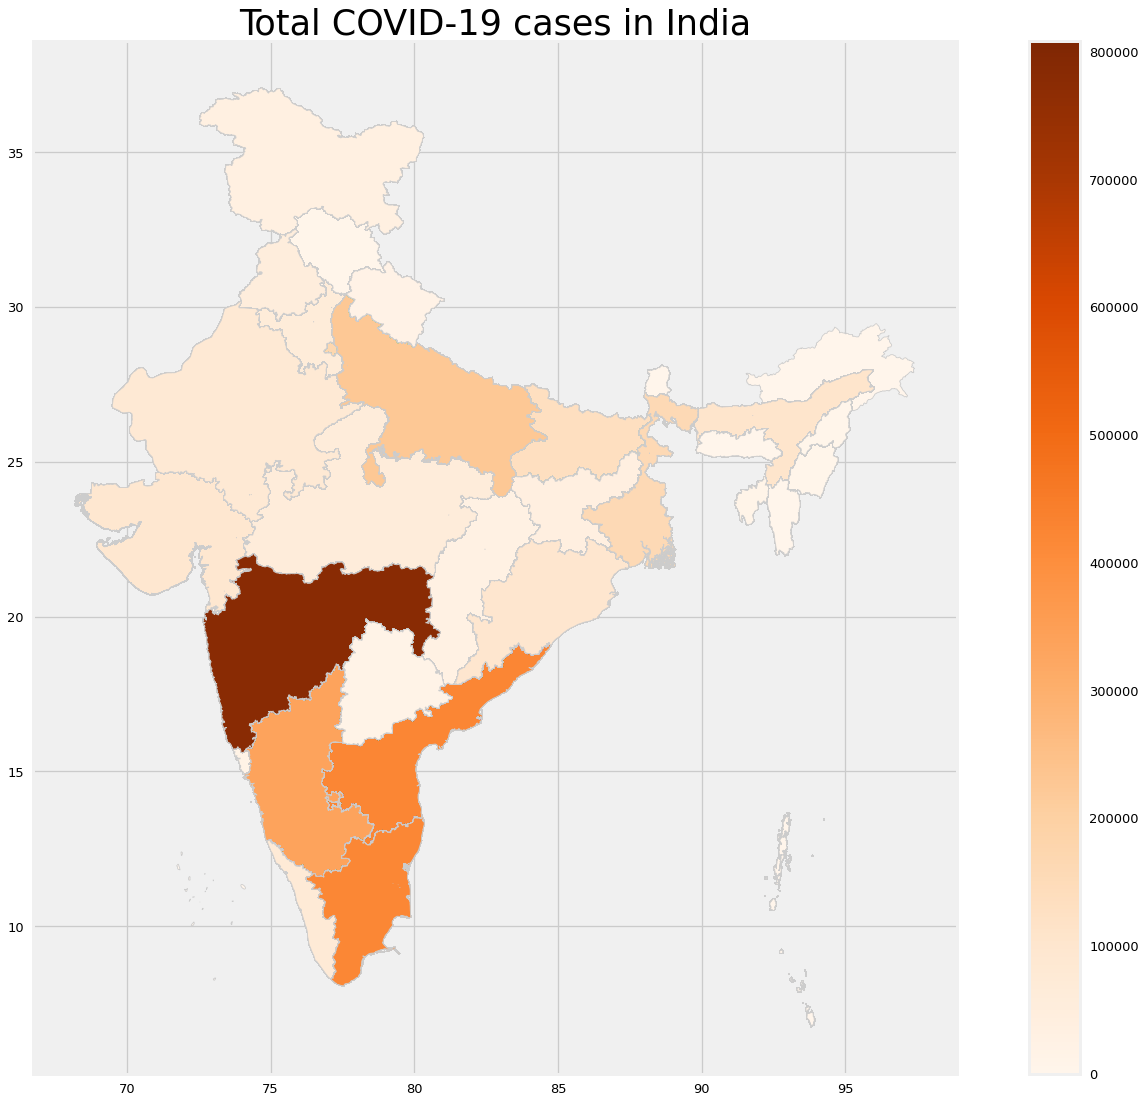

In [95]:
fig, ax = plt.subplots(1, figsize=(23, 19))
ax.axis('on')
ax.set_title('Total COVID-19 cases in India', fontdict={'fontsize': '35', 'fontweight' : '5'})

# plot the figure
merged.plot(column='Confirmed', cmap='Oranges', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)



# Save the output as a PNG image
#fig.savefig("TotalCase_India.png", dpi=100)

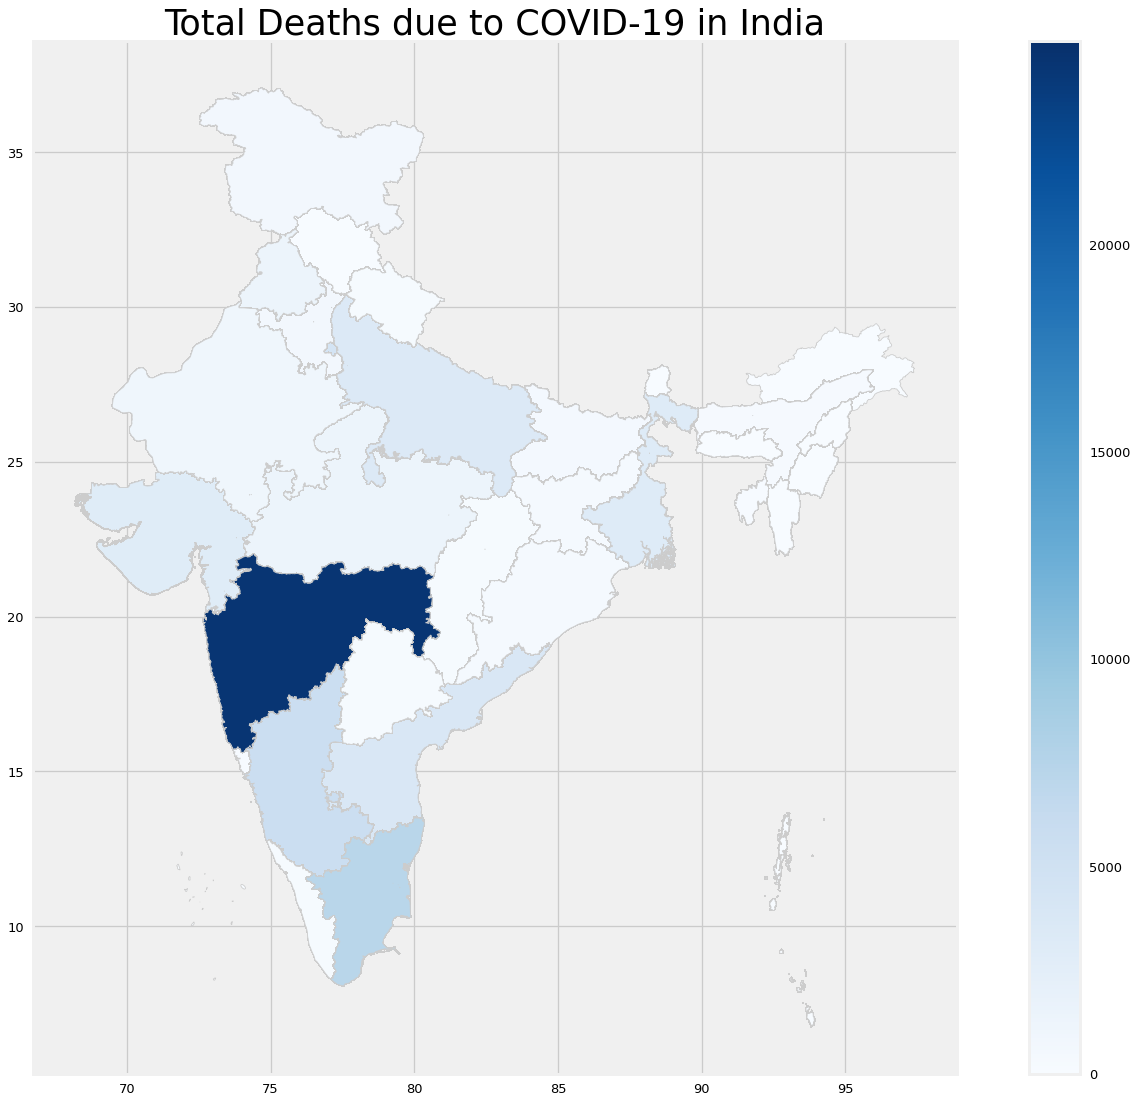

In [96]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(23, 19))
ax.axis('on')
ax.set_title('Total Deaths due to COVID-19 in India', fontdict={'fontsize': '35', 'fontweight' : '5'})

# plot the figure
merged.plot(column='Deaths', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)


# Save the output as a PNG image
#fig.savefig("TotalDeath_India.png", dpi=100)